# True Unfixed Polynomial Regression with SGD

This notebook evaluates convergence behavior and generalization performance of SGD on synthetic polynomial data with randomly generated coefficients. We compare our three stepsize strategies — fixed, halving, and diminishing — using both training and test error over 20 randomized trials. Here, we aim to assess how SGD performs when the model matches the true data-generating process as well as overfitting and underfitting with different degrees.


In [8]:
import sys
sys.path.append("..") 

import numpy as np
import matplotlib.pyplot as plt
from SGD.sgd import SGD
from data.generate_synthetic_data import generate_training_data_unfixed, generate_training_data_fixed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

### Summary of Train/Test Error Over 20 Runs

We generate new synthetic data each time and report mean ± std of final losses.

In [9]:
degrees = [2, 3, 4]   
true_degree = 3         
n_runs = 20
noise = 0.01
m, n = 100, 2

results_summary = {}

for degree in degrees:
    train_losses = {"fixed": [], "halving": [], "diminishing": []}
    test_losses = {"fixed": [], "halving": [], "diminishing": []}
    
    for run in range(n_runs):
        X_raw, _, y, _ = generate_training_data_unfixed(
            m=m, n=n, noise=noise, model_type='polynomial', degree=true_degree
        )

        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly = poly.fit_transform(X_raw)

        scaler = StandardScaler()
        X_poly = scaler.fit_transform(X_poly)

        X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)

        for method in ["fixed", "halving", "diminishing"]:
            sgd = SGD(X_train, y_train, num_iterations=5000, noise=noise)
            w, obj, grad, dist = sgd.optimize(stepsize_type=method)
            train_losses[method].append(obj[-1])
            test_pred = X_test @ w[1:] + w[0]
            test_loss = np.mean((test_pred - y_test) ** 2)
            test_losses[method].append(test_loss)

    results_summary[degree] = {"train": train_losses, "test": test_losses}

# --- Print summary
for degree in degrees:
    print(f"\nDegree {degree}:")
    for method in ["fixed", "halving", "diminishing"]:
        tr = results_summary[degree]["train"][method]
        te = results_summary[degree]["test"][method]
        print(f"{method.capitalize()} Results:")
        print(f"  Train Loss  - Mean: {np.mean(tr):.4f}, Std: {np.std(tr):.4f}")
        print(f"  Test Loss   - Mean: {np.mean(te):.4f}, Std: {np.std(te):.4f}")



Degree 2:
Fixed Results:
  Train Loss  - Mean: 0.0010, Std: 0.0007
  Test Loss   - Mean: 0.0029, Std: 0.0028
Halving Results:
  Train Loss  - Mean: 0.0009, Std: 0.0007
  Test Loss   - Mean: 0.0028, Std: 0.0028
Diminishing Results:
  Train Loss  - Mean: 0.0011, Std: 0.0012
  Test Loss   - Mean: 0.0035, Std: 0.0037

Degree 3:
Fixed Results:
  Train Loss  - Mean: 0.0003, Std: 0.0004
  Test Loss   - Mean: 0.0012, Std: 0.0009
Halving Results:
  Train Loss  - Mean: 0.0005, Std: 0.0006
  Test Loss   - Mean: 0.0021, Std: 0.0020
Diminishing Results:
  Train Loss  - Mean: 0.0003, Std: 0.0004
  Test Loss   - Mean: 0.0012, Std: 0.0009

Degree 4:
Fixed Results:
  Train Loss  - Mean: 0.0033, Std: 0.0094
  Test Loss   - Mean: 0.0079, Std: 0.0197
Halving Results:
  Train Loss  - Mean: 0.0078, Std: 0.0143
  Test Loss   - Mean: 0.0182, Std: 0.0299
Diminishing Results:
  Train Loss  - Mean: 0.0038, Std: 0.0110
  Test Loss   - Mean: 0.0092, Std: 0.0237


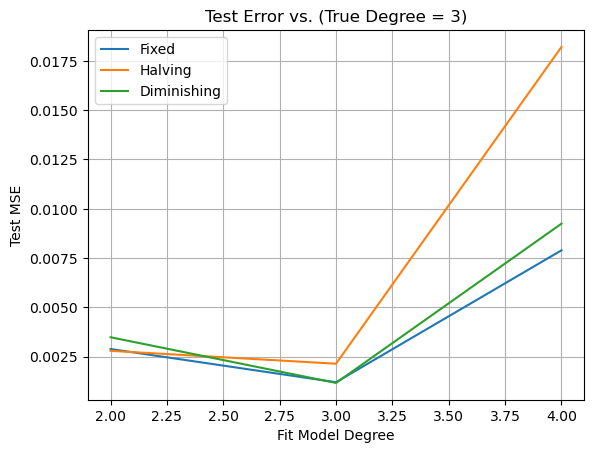

In [10]:
for method in ["fixed", "halving", "diminishing"]:
    test_means = [np.mean(results_summary[d]["test"][method]) for d in degrees]
    plt.plot(degrees, test_means, label=method.capitalize())

plt.xlabel("Fit Model Degree")
plt.ylabel("Test MSE")
plt.title(f"Test Error vs. (True Degree = {true_degree})")
plt.legend()
plt.grid(True)
plt.show()


### Convergence Plots (Single Run)

Here, we show the distance to optimum, gradient norm, and suboptimality gap over 5000 iterations on one synthetic dataset for polynomial degree 3 for the correct model type.

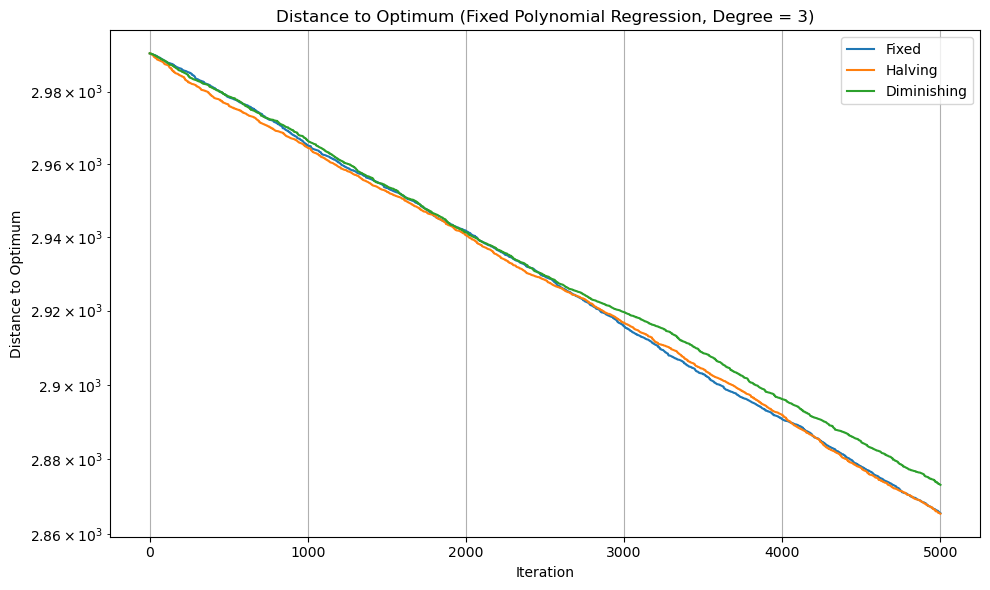

In [11]:
X_raw, X_poly, y, true_params = generate_training_data_fixed(
    m=100,
    n=2,
    noise=0.01,
    degree=3,
    model_type='polynomial'
)
scaler = StandardScaler()
X_poly = scaler.fit_transform(X_poly)

results = {}
for method in ["fixed", "halving", "diminishing"]:
    sgd = SGD(X_poly, y, num_iterations=5000, noise=0.01)
    w, obj, grad, dist = sgd.optimize(stepsize_type=method)
    results[method] = {
        "w": w,
        "obj": obj,
        "grad": grad,
        "dist": dist
    }

# Plot distance to optimum
plt.figure(figsize=(10, 6))
for method in results:
    plt.plot(results[method]["dist"], label=method.capitalize())
plt.xlabel("Iteration")
plt.ylabel("Distance to Optimum")
plt.yscale("log")
plt.title("Distance to Optimum (Fixed Polynomial Regression, Degree = 3)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

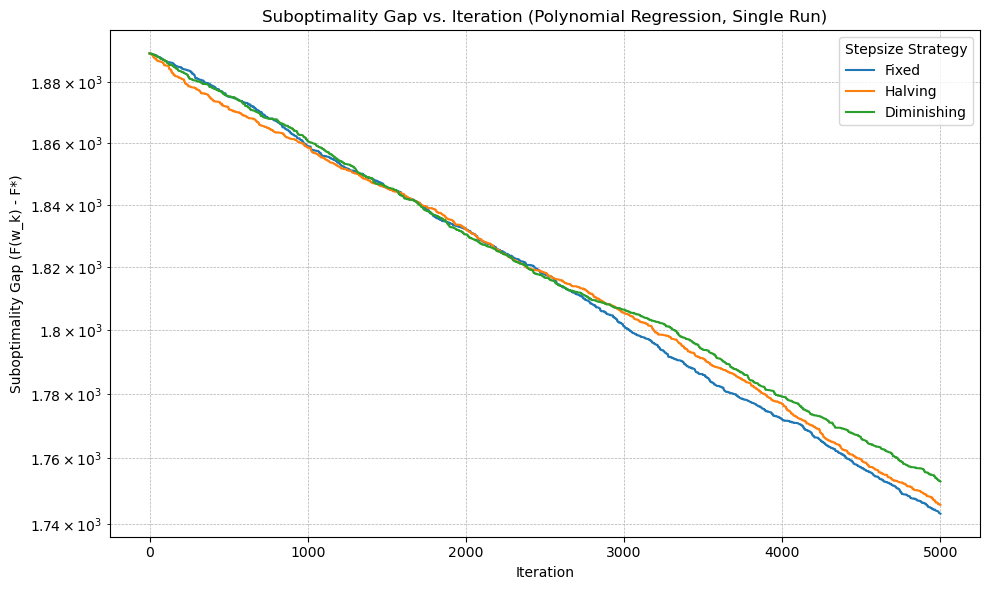

In [12]:
plt.figure(figsize=(10, 6))
plt.yscale("log")

for method in results:
    subopt_gap = results[method]["obj"] - sgd.F_star
    plt.plot(subopt_gap, label=method.capitalize())

plt.xlabel("Iteration")
plt.ylabel("Suboptimality Gap (F(w_k) - F*)")
plt.title("Suboptimality Gap vs. Iteration (Polynomial Regression, Single Run)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(title="Stepsize Strategy")
plt.tight_layout()
plt.show()

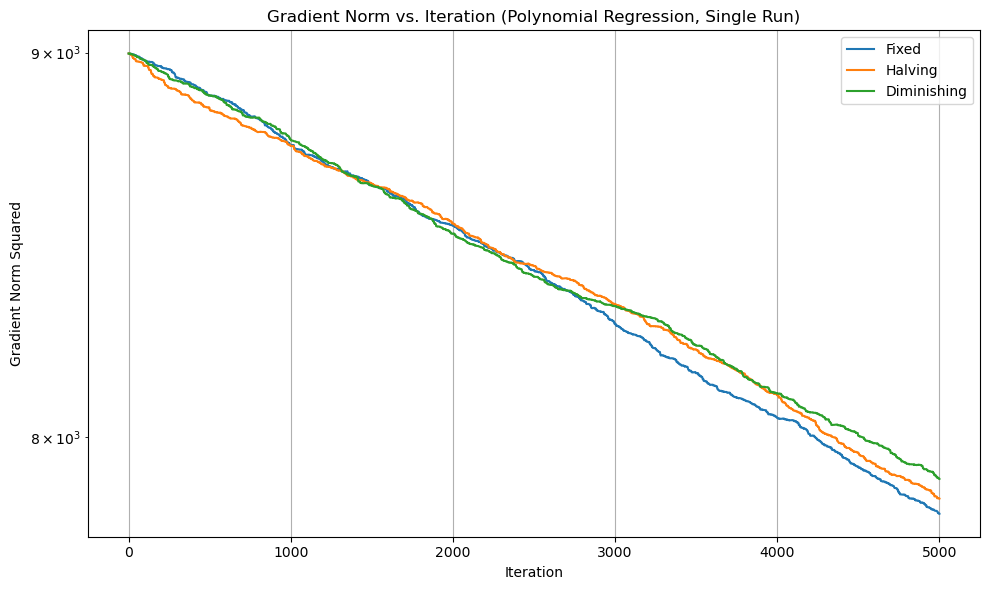

In [13]:
plt.figure(figsize=(10, 6))
for method in results:
    plt.plot(results[method]["grad"], label=method.capitalize())  
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm Squared")
plt.yscale("log")
plt.title("Gradient Norm vs. Iteration (Polynomial Regression, Single Run)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Theoretical Constants

The following constants were computed from the problem to derive the various stepsizes.

In [14]:

print("SGD Parameters for Fixed Polynomial Run:")
print("="*60)
print(f"L (Lipschitz constant): {sgd.L:.4f}")
print(f"c: {sgd.c:.4f}")
print(f"M_G: {sgd.M_G:.4f}")
print(f"M: {sgd.M:.4f}")
print(f"M_V: {sgd.M_V:.4f}")
print(f"mu: {sgd.mu:.4f}")
print(f"mu_G: {sgd.mu_G:.4f}")
print(f"Diminishing stepsize (beta): {sgd.beta:.6f}")
print(f"Diminishing stepsize (gama): {sgd.gamma:.6f} \n")
print(f"Fixed stepsize (alpha): {sgd.fixed_alpha:.6f}")

print("\n" + "="*60)
print("True Parameters (used to generate synthetic data):")
print(f"A: {true_params['A']}")
print(f"b: {true_params['b']}")

print("\nLearned Parameters from Each Stepsize Strategy:")
print("-" * 60)
for method in results:
    w_method = results[method]["w"]
    print(f"{method.capitalize()} stepsize:")
    print(f"  Bias term (w_0): {w_method[0]:.4f}")
    print(f"  Weights (w_1,w_2: {w_method[1:]}")
    print(obj[-1])

SGD Parameters for Fixed Polynomial Run:
L (Lipschitz constant): 4.8903
c: 0.0009
M_G: 63870.8256
M: 0.0010
M_V: 63869.8256
mu: 1.0000
mu_G: 1.0000
Diminishing stepsize (beta): 1077.864336
Diminishing stepsize (gama): 336668303.519587 

Fixed stepsize (alpha): 0.000003

True Parameters (used to generate synthetic data):
A: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
b: 1.0

Learned Parameters from Each Stepsize Strategy:
------------------------------------------------------------
Fixed stepsize:
  Bias term (w_0): 0.8507
  Weights (w_1,w_2: [0.33230874 0.41447746 0.34316118 0.5614984  0.44030803 0.33972624
 0.54157425 0.56792529 0.43662311]
1752.928464334963
Halving stepsize:
  Bias term (w_0): 0.8672
  Weights (w_1,w_2: [0.31000365 0.41968375 0.31598103 0.54051877 0.44369119 0.31030513
 0.50592198 0.54501489 0.43961991]
1752.928464334963
Diminishing stepsize:
  Bias term (w_0): 0.8026
  Weights (w_1,w_2: [0.31142188 0.38424619 0.32495572 0.51460721 0.40831716 0.32535423
 0.49646273 0.51558